<a href="https://colab.research.google.com/github/Anuj347/Load-demand-forecast-LSTM/blob/main/Electricity_forecast_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
df = pd.read_csv('Electricity+Consumption.csv')

In [3]:
df.head()

,DATE,Humidity,Temperature,Electricity
0,2020-01-01 00:00:00 EST,92,-1.1,914
1,2020-01-01 01:00:00 EST,92,-1.5,887
2,2020-01-01 02:00:00 EST,91,-1.5,865
3,2020-01-01 03:00:00 EST,88,-1.1,852
4,2020-01-01 04:00:00 EST,87,-1.3,852


In [4]:
#humidity and Temperature are predictor(independant variables) whereas electricity is our target variable

In [5]:
df.dropna(inplace =True)

In [9]:
df1 = df.drop(['DATE'],axis = 1)

<Axes: >

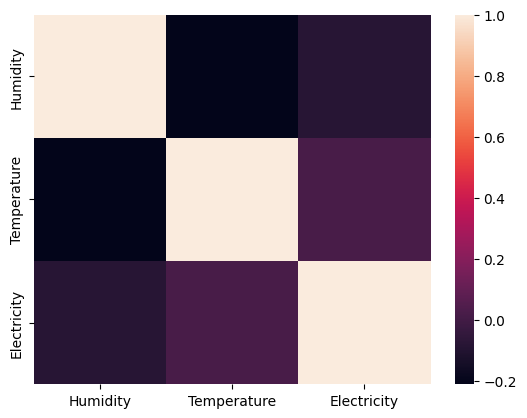

In [10]:
sn.heatmap(df1.corr())

**Analysis**

correlation of electricity with humidity and temperature is weak but lets hope that even if it is poor that can help our model to perform better

In [11]:
training_set = df.iloc[:8712,1:4].values
test_set = df.iloc[8712:,1:4].values #last 48hrs for test

In [12]:
#in case of multivariate, it is a must to normalize

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

test_set_scaled = sc.fit_transform(test_set)

test_set_scaled = test_set_scaled[:, 0:2]
#just independent variable not electricity(target variable)

In [13]:
X_train = []
Y_train = []
WS = 24

for i in range(WS,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-WS:i,0:3])
    Y_train.append(training_set_scaled[i,2])   #since 2 is target variable


X_train , Y_train = np.array(X_train) , np.array(Y_train)
#we need them in the form of array
#there are now 24 features in X_train as the window size is 24
#so when you give a value to Window size, your whole data is multiplied by that
#amount since the no . of features increases

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],3))
#ensuring the shape of X_train before fitting it to the model


# **Modelling**

In [14]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [15]:
Model = Sequential()

Model.add(LSTM(units=70,return_sequences= True, input_shape=(X_train.shape[1],3)))#more the units more time better result its hybrid
Model.add(Dropout(0.2)) #just droping sme random neurons to avoid overfitting

Model.add(LSTM(units=70,return_sequences= True))#more the units more time better result its hybrid
Model.add(Dropout(0.2))

Model.add(LSTM(units=70,return_sequences= True))
Model.add(Dropout(0.2))

Model.add(LSTM(units=70))
Model.add(Dropout(0.2))

Model.add(Dense(units =1)) #for output

Model.compile(optimizer='adam',loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Fitting the Data

Epoch 1/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - loss: 0.0230
Epoch 2/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - loss: 0.0070
Epoch 3/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - loss: 0.0058
Epoch 4/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 0.0051
Epoch 5/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - loss: 0.0045
Epoch 6/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 0.0041
Epoch 7/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - loss: 0.0035
Epoch 8/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 85ms/step - loss: 0.0027
Epoch 9/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 34s 59ms/step - loss: 0.0021
Epoch 10/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - loss: 0.0018
Epoch 11/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - loss: 0.0016
Epoch 12/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0015
Epoch 13/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 0.0014
Epoch 14/80
272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 63ms/step - loss: 0.0014
Epoch 15/80
272/272 ━━━━━━━━━

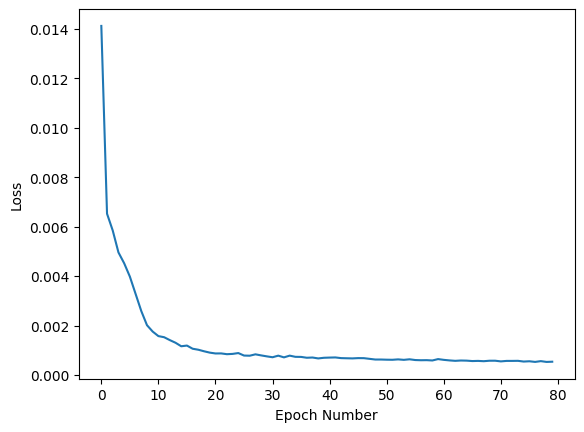

In [16]:
Model.fit(X_train,Y_train,epochs=80,batch_size=32)

plt.plot(range(len(Model.history.history['loss'])),Model.history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

In [18]:
Model.save('LSTM-Multivariate.keras')

In [20]:
from keras.models import load_model
Model = load_model('LSTM-Multivariate.keras')

In [21]:
prediction_test = []

Batch_one = training_set_scaled[-WS:]
Batch_New = Batch_one.reshape((1,WS,3)) # 3 because we have 3 variable 1-target 2-independent

for i in range(48): #48 because it is the range of prediction horizon
    First_prediction= Model.predict(Batch_New)[0]
    #sot the model takes input in batches
    prediction_test.append(First_prediction)

    New_var = test_set_scaled[i,:]

    New_var = New_var.reshape(1,2)

    New_test = np.insert(New_var,2,[First_prediction],axis=1)

    New_test = New_test.reshape(1,1,3)

    Batch_New = np.append(Batch_New[:,1:,:],New_test,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

In [22]:
prediction_test = np.array(prediction_test)

In [23]:
#we cannot use sc because it was used for 3 features hence it will give error

SI = MinMaxScaler(feature_range=(0,1))
y_Scale = training_set[:,2:3]
SI.fit_transform(y_Scale)

array([[0.27878788],
       [0.25541126],
       [0.23636364],
       ...,
       [0.42770563],
       [0.38268398],
       [0.33506494]])

In [24]:
predictions = SI.inverse_transform(prediction_test)

In [25]:
real_values = test_set[:,2:3]

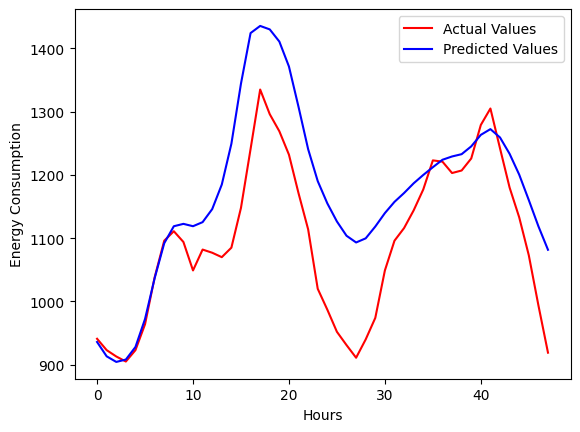

In [26]:
plt.plot(real_values,color='red',label='Actual Values')
plt.plot(predictions,color='blue',label='Predicted Values')
plt.xlabel('Hours')
plt.ylabel('Energy Consumption')
plt.legend()
plt.show()

In [30]:
import math
from sklearn.metrics import mean_squared_error
RMSE = math.sqrt(mean_squared_error(real_values,predictions))
print(RMSE)

102.3070104464185


In [31]:
from sklearn.metrics import r2_score
Rsquare = r2_score(real_values,predictions)
print(Rsquare)

0.3077691800917399


In [32]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_pred))*100

MAPE = mean_absolute_percentage_error(real_values,predictions )
print(MAPE)

6.563845817418647


In [33]:
accuracy= 100-MAPE
print(accuracy)

93.43615418258135
